In [1]:
from astroquery.alma import Alma
import numpy as np
import astropy.units as u
from ast import literal_eval
from astropy import constants as const
import matplotlib.pyplot as plt
import re
import math
from astropy.table import Table

In [2]:
Alma.help()


Most common ALMA query keywords are listed below. These keywords are part of the ALMA ObsCore model, an IVOA standard for metadata representation (3rd column). They were also present in original ALMA Web form and, for backwards compatibility can be accessed with their old names (2nd column).
More elaborate queries on the ObsCore model are possible with `query_sia` or `query_tap` methods
  Description                       Original ALMA keyword               ObsCore keyword                    
-------------------------------------------------------------------------------------------------------

Position
  Source name (astropy Resolver)    source_name_resolver                SkyCoord.from_name                 
  Source name (ALMA)                source_name_alma                    target_name                        
  RA Dec (Sexagesimal)              ra_dec                              s_ra, s_dec                        
  Galactic (Degrees)                galactic                   

In [3]:
Alma.help_tap()

Table to query is "voa.ObsCore".
For example: "select top 1 * from ivoa.ObsCore"
The scheme of the table is as follows.

  Name                 Type            Unit       Description
------------------------------------------------------------------------------------------
  access_format        char(9)                    Content format of the data
  access_url           char(72*)                  URL to download the data
  antenna_arrays       char(660*)                 Blank-separated list of Pad:Antenna pairs, i.e., A109:DV09 J504:DV02 J505:DV05 for antennas DV09, DV02 and DV05 sitting on pads A109, J504, and J505, respectively.
  asdm_uid             char(32*)                  UID of the ASDM containing this Field.
  authors              char(4000*)                Full list of first author and all co-authors
  band_list            char(30*)                  Space delimited list of bands
  bandwidth            double          Hz         Total Bandwidth
  bib_reference        char(40

In [4]:
result = Alma.query_tap(f"SELECT * FROM ivoa.obscore WHERE proposal_id like '2019.%' AND scientific_category NOT like 'Sun' AND scientific_category NOT like 'Solar system' AND scan_intent like 'TARGET' AND science_observation like 'T'").to_table()

In [5]:
len(result)

50648

In [7]:
result.columns

<TableColumns names=('obs_publisher_did','obs_collection','facility_name','instrument_name','obs_id','dataproduct_type','calib_level','target_name','s_ra','s_dec','s_fov','s_region','s_resolution','t_min','t_max','t_exptime','t_resolution','em_min','em_max','em_res_power','pol_states','o_ucd','access_url','access_format','proposal_id','data_rights','gal_longitude','gal_latitude','band_list','em_resolution','bandwidth','antenna_arrays','is_mosaic','obs_release_date','spatial_resolution','frequency_support','frequency','velocity_resolution','obs_creator_name','pub_title','first_author','authors','pub_abstract','publication_year','proposal_abstract','schedblock_name','proposal_authors','sensitivity_10kms','cont_sensitivity_bandwidth','pwv','group_ous_uid','member_ous_uid','asdm_uid','obs_title','type','scan_intent','science_observation','spatial_scale_max','qa2_passed','bib_reference','science_keyword','scientific_category','lastModified')>

In [9]:
result.remove_columns(['authors','bib_reference','first_author','obs_collection','obs_creator_name','obs_title','proposal_authors','pub_abstract','pub_title'])b

In [375]:
np.unique(result['scientific_category'])

Active galaxies
Cosmology
Disks and planet formation
Galaxy evolution
ISM and star formation
Local Universe
Stars and stellar evolution


In [10]:
idx = result['target_name'] == 'Europa'
result.remove_rows(idx)

In [1]:
result.dtype

NameError: name 'result' is not defined

In [14]:
result.remove_columns(['s_region','obs_release_date','lastModified'])

In [16]:
result.write('taq_query_results_20220113.csv')

In [2]:
result = Table.read('taq_query_results_20220113.csv')

In [3]:
array = np.full(np.shape(result['s_fov']),'',dtype='<U4')

In [4]:
for i in np.arange(len(result)):
    myrow = result[i]
    if re.search('7M',myrow['schedblock_name']):
        array[i] = '7m'
    elif (re.search('TM1',myrow['schedblock_name']) or re.search('TM2',myrow['schedblock_name'])):
        array[i] = '12m'
    elif (re.search('TP',myrow['schedblock_name'])):
        array[i] = 'TP'
        

In [5]:
if 'array' not in result.columns:
    result.add_column(array,name='array')
else:
    result.replace_column('array',array)


In [6]:
#s_resolution is supposedly in deg, but comparing to the ALMA archive directly it's in arcsec.
points_per_fov = (result['s_fov']*3600.0/2.0)**2/(result['s_resolution']/2.0)**2

In [7]:
if 'points_per_fov' not in result.columns:
    result.add_column(points_per_fov,name='points_per_fov')
else:
    result.replace_column('points_per_fov',points_per_fov)

In [8]:
# again the bandwidth is supposedly in GHz, but really in Hz
# the velocity and frequency resolution for each member_ous_uid is the same and it's the minimum over the window.
# velocity resolution is correct with m/s. it looks like it's the min velocity resolution over all windows.
# frequency is also correct with GHz. But it looks like it's the central frequency of all four windows. [BUT THIS 
# IS A BUG ACCORDING TO FELIX]
result['proposal_id','schedblock_name','member_ous_uid','frequency','bandwidth','frequency_support']

proposal_id,schedblock_name,member_ous_uid,frequency,bandwidth,frequency_support
str14,str18,str22,float64,float64,str1593
2019.1.01729.S,UGC12915_a_03_TM1,uid://A001/X1465/X33e,92.3975914534634,1875000000.0,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
2019.1.01729.S,UGC12915_a_03_TM1,uid://A001/X1465/X33e,92.3975914534634,1875000000.0,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
2019.1.01729.S,UGC12915_a_03_TM1,uid://A001/X1465/X33e,92.3975914534634,1875000000.0,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
2019.1.01729.S,UGC12915_a_03_TM1,uid://A001/X1465/X33e,92.3975914534634,1875000000.0,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
2019.1.01729.S,ugc_1291_a_06_TM1,uid://A001/X1465/X342,221.99912920543306,1875000000.0,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
2019.1.01729.S,ugc_1291_a_06_TM1,uid://A001/X1465/X342,221.99912920543306,1875000000.0,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
2019.1.01729.S,ugc_1291_a_06_TM1,uid://A001/X1465/X342,221.99912920543306,1875000000.0,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
2019.1.01729.S,ugc_1291_a_06_TM1,uid://A001/X1465/X342,221.99912920543306,1875000000.0,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
2019.1.01031.S,CN13_b_03_TM1,uid://A001/X1465/X1c9c,107.43675793166435,58593750.0,"[99.50..101.37GHz,2257.81kHz,1.3mJy/beam@10km/s,53.3uJy/beam@native, XX XY YX YY] U [101.39..103.26GHz,2257.81kHz,1.3mJy/beam@10km/s,53.4uJy/beam@native, XX XY YX YY] U [113.16..113.22GHz,122.07kHz,1.2mJy/beam@10km/s,302.7uJy/beam@native, XX XY YX YY] U [113.50..113.56GHz,122.07kHz,1.7mJy/beam@10km/s,427.7uJy/beam@native, XX XY YX YY] U [115.26..115.37GHz,122.07kHz,1.7mJy/beam@10km/s,302.6uJy/beam@native, XX XY YX YY]"


In [9]:
freq = const.c.value*(1.0/result['em_min'] + 1.0/result['em_max'])/1e9/2.0 #GHz

spec_width = (freq / result['em_res_power'])*1e6 #kHz

In [10]:
if 'spw_freq' not in result.columns:
    result.add_column(freq,name='spw_freq')
else:
    result.replace_column('spw_freq',freq)
    
if 'spw_specwidth' not in result.columns:
    result.add_column(spec_width,name='spw_specwidth')
else:
    result.replace('spw_specwidth',spec_width)

In [11]:
idx = result['array'] == '12m'
result[idx]['bandwidth','spw_specwidth','frequency_support']

bandwidth,spw_specwidth,frequency_support
float64,float64,str1593
1875000000.0,1117.0047465993594,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
1875000000.0,3941.762984004958,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
1875000000.0,1139.9679210577744,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
1875000000.0,1116.7621155409308,"[84.62..86.49GHz,1128.91kHz,1.2mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [86.37..88.24GHz,1128.91kHz,1.1mJy/beam@10km/s,45.1uJy/beam@native, XX YY] U [96.41..98.28GHz,1128.91kHz,1.1mJy/beam@10km/s,43.8uJy/beam@native, XX YY] U [98.31..100.18GHz,3904.30kHz,1mJy/beam@10km/s,43.9uJy/beam@native, XX YY]"
1875000000.0,1930.1740304432176,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
1875000000.0,1930.279031196216,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
1875000000.0,1946.636528338172,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
1875000000.0,1946.5488987925798,"[212.96..214.83GHz,1938.48kHz,3.8mJy/beam@10km/s,233.4uJy/beam@native, XX YY] U [215.66..217.53GHz,1938.48kHz,3.8mJy/beam@10km/s,233.7uJy/beam@native, XX YY] U [226.66..228.53GHz,1938.48kHz,3.8mJy/beam@10km/s,240.9uJy/beam@native, XX YY] U [229.17..231.04GHz,1938.48kHz,3.8mJy/beam@10km/s,241.2uJy/beam@native, XX YY]"
58593750.0,122.09602703410684,"[99.50..101.37GHz,2257.81kHz,1.3mJy/beam@10km/s,53.3uJy/beam@native, XX XY YX YY] U [101.39..103.26GHz,2257.81kHz,1.3mJy/beam@10km/s,53.4uJy/beam@native, XX XY YX YY] U [113.16..113.22GHz,122.07kHz,1.2mJy/beam@10km/s,302.7uJy/beam@native, XX XY YX YY] U [113.50..113.56GHz,122.07kHz,1.7mJy/beam@10km/s,427.7uJy/beam@native, XX XY YX YY] U [115.26..115.37GHz,122.07kHz,1.7mJy/beam@10km/s,302.6uJy/beam@native, XX XY YX YY]"


Below is a brute force way of figuring out the native number of channels. Right now I've only done for the 12m. I should probably figure out the 7m, but the 7m mosaics aren't as large.

I have one project (2019.1.01719.S, PI: Lorant Sjouwerman) where the pipeline weblog shows 3840 channels with 244kHz native resolution. Somehow my archive calculation gives the resolution of 293kHz. I don't know why. It's Lorant's project so it's probably weird.

I'm also probably not doing quite the right thing for polarization states, but the below more or less works.

Due to the ACA vs. BL correlator, the ACA correlator generates the same spectral resolution, but with a different nchan. So I think I can account for by moving the 'if 12m statement down. Or just copy the whole tree and add 7m separately.


In [12]:
nchan = np.zeros(np.shape(result['array']))
for i in np.arange(len(result)):
    
    if result[i]['pol_states'] == '/XX/':
        factor = 2
    elif result[i]['pol_states'] == '/XX/XY/YX/YY/':
        factor = 0.5
    else:
        factor = 1
    
    if result[i]['array'] == '12m':
        base_chan = 3840
    elif result[i]['array'] == '7m':
        base_chan = 4096
    elif result[i]['array'] == 'TP':
        base_chan = 4096
    else:
        print('array not found')
        continue
   

    if (result[i]['bandwidth'] == 2000e6) & (result[i]['spw_specwidth'] > 15000):
        nchan[i] = 128 * factor
    elif (result[i]['bandwidth'] >=  1875e6):
        if result[i]['spw_specwidth'] > 7700.0:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] > 3800:
            nchan[i] = (base_chan / 8) * factor
        elif result[i]['spw_specwidth'] > 1900:
            nchan[i] = (base_chan / 4) * factor
        elif result[i]['spw_specwidth'] > 1100:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 900:
            nchan[i] = base_chan * factor
        # single pol smallest resolution
        elif result[i]['spw_specwidth'] > 480:
            nchan[i] = base_chan * 2
        else:
            print('spw_specwidth not recognized: ', result[i]['bandwidth','spw_specwidth'])
    elif (result[i]['bandwidth'] >= 937.5e6) :
        if result[i]['spw_specwidth'] > 3800:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] > 1900:
            nchan[i] = (base_chan/8) * factor
        elif result[i]['spw_specwidth'] > 960:
            nchan[i] = (base_chan/4) * factor
        elif result[i]['spw_specwidth'] > 560:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 480:
            nchan[i] = base_chan * factor
        # fix for Lorant's weird project '2019.1.01719.S' and 2019.2.00093.S
        elif (result[i]['spw_specwidth'] > 280.0):
            nchan[i] = base_chan
        else:
            print('spw_specwidth not recognized', result[i]['bandwidth','spw_specwidth','proposal_id','member_ous_uid'])
    elif (result[i]['bandwidth'] >= 468.75e6):
        if result[i]['spw_specwidth'] > 1950:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] > 970:
            nchan[i] = (base_chan/8) * factor
        elif result[i]['spw_specwidth'] > 480:
            nchan[i] = (base_chan/4) * factor
        elif result[i]['spw_specwidth'] > 280:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 240:
            nchan[i] = base_chan * factor
        else:
            print('spw_specwidth not recognized', result[i]['bandwidth','spw_specwidth'])
    elif (result[i]['bandwidth'] >= 234.375e6):
        if result[i]['spw_specwidth'] > 970:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] > 480:
            nchan[i] = (base_chan/8) * factor
        elif result[i]['spw_specwidth'] > 240:
            nchan[i] = (base_chan/4) * factor
        elif result[i]['spw_specwidth'] > 138:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 118:
            nchan[i] = (base_chan) * factor
        else:
            print('spw_specwidth not recognized', result[i]['bandwidth','spw_specwidth'])
    elif (result[i]['bandwidth'] >= 117.1875e6) :
        if result[i]['spw_specwidth'] > 480:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] > 240:
            nchan[i] = (base_chan/8) * factor
        elif result[i]['spw_specwidth'] > 118:
            nchan[i] = (base_chan/4) * factor
        elif result[i]['spw_specwidth'] > 65:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 56:
            nchan[i] = (base_chan) * factor
        else:
            print('spw_specwidth not recognized', result[i]['bandwidth','spw_specwidth'])
    elif (result[i]['bandwidth'] >= 58.593750e6):
        if result[i]['spw_specwidth'] > 240:
            nchan[i] = (base_chan/16) * factor
        elif result[i]['spw_specwidth'] >120:
            nchan[i] = (base_chan/8) * factor
        elif result[i]['spw_specwidth'] > 56:
            nchan[i] = (base_chan/4) * factor
        elif result[i]['spw_specwidth'] > 30:
            nchan[i] = (base_chan/2) * factor
        elif result[i]['spw_specwidth'] > 25:
            nchan[i] = (base_chan) * factor
        else:
            print('spw_specwidth not recognized', result[i]['bandwidth','spw_specwidth'])
    

In [13]:
if 'spw_nchan' in result.columns:
    result.replace_column('spw_nchan',nchan)
else:
    result.add_column( nchan, name='spw_nchan')

In [14]:
result[2011:2018]['proposal_id','member_ous_uid','bandwidth','spw_specwidth','pol_states','spw_nchan']

proposal_id,member_ous_uid,bandwidth,spw_specwidth,pol_states,spw_nchan
str14,str22,float64,float64,str13,float64
2019.2.00062.S,uid://A001/X14c3/X12ec,500000000.0,281.4474051339044,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12ec,500000000.0,282.9335493420984,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12ec,125000000.0,70.51323596057169,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12e8,125000000.0,70.51287857240375,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12e8,500000000.0,281.4459962035718,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12e8,500000000.0,282.93215062249556,/XX/YY/,2048.0
2019.2.00062.S,uid://A001/X14c3/X12e8,500000000.0,282.93768876004805,/XX/YY/,2048.0


In [15]:
def calc_nchan_max(cube_limit, points_per_fov, pixels_per_beam=25.0, frac_fov=1.0, nbin=1.0, chan_limit = 7680.0):
    # default: assumes 25 pixels per resolution element
    # 4.0 because fits images are single precision
    # 1.0 = assuming imaging full fov (i.e., out to 0.2)
    # nbin = 1 -- number of channels binned together
    # add in factor of 2.6 since that gives better results compared to pipeline
    npix = 2.6 * (points_per_fov * frac_fov) * pixels_per_beam * 4.0 
    nchan_max = cube_limit * nbin * 1e9 / npix
    if type(points_per_fov) == float:
        if nchan_max > chan_limit:
            nchan_max = chan_limit
    else:
        nchan_max[nchan_max > chan_limit] = chan_limit
    return nchan_max

In [16]:
# calculate mitigated projects
cube_limit = 40 #GB

mitigated = np.full(np.shape(result['spw_nchan']),False)

print(np.sum(mitigated))

nchan_max = calc_nchan_max(cube_limit, result['points_per_fov'])
idx = result['spw_nchan'] > nchan_max

mitigated[idx] = True

print(np.sum(mitigated))

0
1136


In [17]:
# calculate failed mitigations
cube_limit = 60 #GBT
frac_fov = math.log(0.7)/math.log(0.2)
print("fraction of FOV: ", frac_fov)

failed_mitigation = np.full(np.shape(result['spw_nchan']),False)

nchan_fail = calc_nchan_max(cube_limit, result['points_per_fov'],
                            nbin=1.0, pixels_per_beam=9.0, frac_fov=math.log(0.7)/math.log(0.2) )
idx = result['spw_nchan'] > nchan_fail

failed_mitigation[idx] = True

print(np.sum(failed_mitigation))

fraction of FOV:  0.22161460295122554
92


In [18]:
# calculate failed mitigations
cube_limit = 60 #GBT
frac_fov = math.log(0.7)/math.log(0.2)
print("fraction of FOV: ", frac_fov)

failed_mitigation_nbin2 = np.full(np.shape(result['spw_nchan']),False)

nchan_fail_nbin2 = calc_nchan_max(cube_limit, result['points_per_fov'],
                            nbin=2.0, pixels_per_beam=9.0, frac_fov=math.log(0.7)/math.log(0.2) )
idx = result['spw_nchan'] > nchan_fail_nbin2

failed_mitigation_nbin2[idx] = True

print(np.sum(failed_mitigation_nbin2))


fraction of FOV:  0.22161460295122554
20


In [19]:
if 'spw_nchan_max' in result.columns:
    result.replace_column('spw_nchan_max',nchan)
else:
    result.add_column(nchan_max,name='spw_nchan_max')

if 'mitigated' in result.columns:
    result.replace_column('mitigated', mitigated)
else:
    result.add_column(mitigated,name='mitigated')
    
if 'failed_mitigation_nbin1' in result.columns:
    result.replace_column('failed_mitigation_nbin1',failed_mitigation)
else:
    result.add_column(failed_mitigation,name='failed_mitigation_nbin1')
    
if 'failed_mitigation_nbin2' in result.columns:
    result.replace_column('failed_mitigation_nbin2',failed_mitigation)
else:
    result.add_column(failed_mitigation,name='failed_mitigation_nbin2')

In [21]:
nspw = np.zeros(len(result['frequency_support']))

for i  in np.arange(len(result['frequency_support'])) :
    freq_support = result[i]['frequency_support']
    nspw[i] = len(freq_support.split('U'))

In [22]:
if 'nspw' in result.columns:
    result.replace_column('nspw',nspw)
else:
    result.add_column(nspw,name='nspw')

In [23]:
# calculate the number of sources per mous
mous_list = np.unique(result['member_ous_uid'])

ntarget_arr = np.zeros(len(result['member_ous_uid']))

for mous in mous_list:
    idx = (result['member_ous_uid'] == mous) 
    ntarget = len(np.unique(result[idx]['target_name']))
    ntarget_arr[idx] = ntarget

In [24]:
if 'ntarget' not in result.columns:
    result.add_column(ntarget_arr,name='ntarget')
else:
    result.replace_column('ntarget',ntarget_arr)

In [25]:
result.write('result_table_cycle7_with_calc_values.csv')

# Making Plots

Poster child is 2017.1.00983.S, A001/X12a3/X3be, G10.29_a_06_TM1
resolution = 0.682arcsec
FOV = 84.202 arcsec
max n chan = 3840

In [26]:
points_per_fov_983 = (84.202/2.0)**2 / (0.682/2)**2
nchan_983 = 3840

In [27]:
config_res = [3.38,2.30,1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057,0.042]

config_dict = {}

i=1
for res in config_res:
    pb = 6300/100.0
    points_per_fov = (pb)**2 / res**2
    print(str(i)+","+str(res)+","+str(points_per_fov))
    config_dict['C'+str(i)] = {'res':res, 'points_per_fov': points_per_fov,'pb':pb}
    i=i+1

1,3.38,347.41430622177097
2,2.3,750.2835538752364
3,1.42,1968.3594524895855
4,0.918,4709.727028066129
5,0.545,13362.511573099906
6,0.306,42387.543252595155
7,0.211,89148.94094921499
8,0.096,430664.0625
9,0.057,1221606.648199446
10,0.042,2250000.0


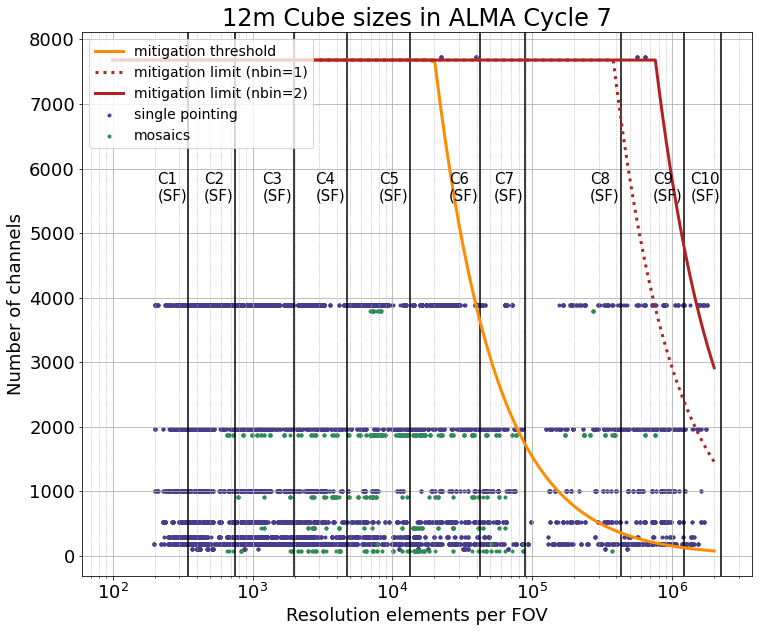

In [90]:
plt.figure(figsize=(12,10))

# calculate line for maximum number of channels
cube_limit = 40 #  GB
points_per_fov = np.linspace(100,2e6,1000)
nchan_max = calc_nchan_max(cube_limit, points_per_fov)

# calculate limit at which only one cube produced once mitigated
# I'm leaving this off since it seems to depend on max product size.
#nchan_max_1cube = calc_nchan_max(0.5 * max_cube_limit, points_per_fov, 
#                                 nbin=2.0,pixels_per_beam=9.0,frac_fov=math.log(0.7)/math.log(0.2))

# calculate maximum mitigation limit -- depends on nbin which may not be able to be set
max_cube_limit = 60 # GB
nchan_max_fail_nbin1 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=1.0, pixels_per_beam=9.0, frac_fov=0.22)

nchan_max_fail_nbin2 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=2.0, pixels_per_beam=9.0, frac_fov=0.22)

# add configs
for config in config_dict.keys():
    plt.axvline(config_dict[config]['points_per_fov'], color= 'black')
    plt.text(config_dict[config]['points_per_fov'] * 0.60, 5500, config + '\n(SF)',size=15)
    #print(config_dict[config],config_dict[config]['points_per_fov'])

# select only 12m points
mosaic_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'T') 
sp_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'F') 

plt.scatter(result[sp_12m]['points_per_fov'],result[sp_12m]['spw_nchan']+50,
            marker='.',label='single pointing',facecolor='darkslateblue')
plt.scatter(result[mosaic_12m]['points_per_fov'],result[mosaic_12m]['spw_nchan']-50,
            marker='.',label='mosaics',facecolor='seagreen')
#plt.scatter([points_per_fov_983],[nchan_983],color='magenta',marker='*',s=50,label='2017.1.00983.S')

plt.xticks(size=18)
plt.xlabel('Resolution elements per FOV',size=18)
plt.xscale('log')
plt.yticks(size=18)
plt.ylabel('Number of channels',size=18)
plt.title('12m Cube sizes in ALMA Cycle 7',size=24)

plt.plot(points_per_fov,nchan_max,color='darkorange',label='mitigation threshold', linewidth=3)
#plt.plot(points_per_fov,nchan_max_1cube,color='orange',linestyle=':',label='only one cube (est)',linewidth=3)
plt.plot(points_per_fov,nchan_max_fail_nbin1, color='firebrick',label='mitigation limit (nbin=1)',linewidth=3,
        linestyle=':')
plt.plot(points_per_fov,nchan_max_fail_nbin2, color='firebrick',label='mitigation limit (nbin=2)',linewidth=3)


plt.grid(which='major')
plt.grid(which='minor',linestyle=':')

plt.legend(loc='upper left',prop={'size':14})

#plt.axvspan(5e4,1e5,alpha=0.2,color='gray')
#plt.axvspan(3e4,6e4,alpha=0.2,color='gray')
#plt.axvspan(1e3,2e3,alpha=0.2,color='gray')
#plt.axhspan(1500,3838,alpha=0.2,colorb='gray')
plt.savefig("cycle7_12m_cube_size.png")

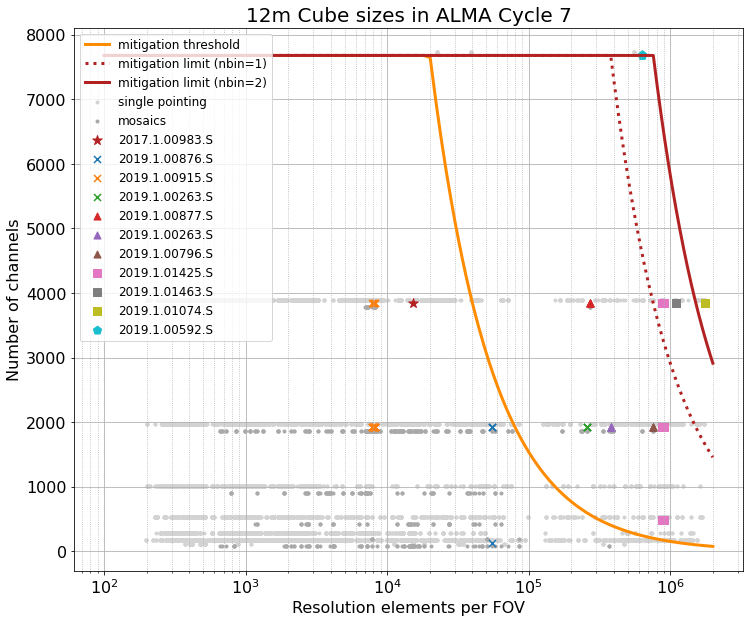

In [79]:
plt.figure(figsize=(12,10))

# calculate limit at which only one cube produced once mitigated
# I'm leaving this off since it seems to depend on max product size.
#nchan_max_1cube = calc_nchan_max(0.5 * max_cube_limit, points_per_fov, 
#                                 nbin=2.0,pixels_per_beam=9.0,frac_fov=math.log(0.7)/math.log(0.2))

# calculate maximum mitigation limit -- depends on nbin which may not be able to be set
max_cube_limit = 60 # GB
nchan_max_fail_nbin1 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=1.0, pixels_per_beam=9.0, frac_fov=0.22)

nchan_max_fail_nbin2 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=2.0, pixels_per_beam=9.0, frac_fov=0.22)

# select only 12m points
mosaic_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'T') 
sp_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'F') 

plt.scatter(result[sp_12m]['points_per_fov'],result[sp_12m]['spw_nchan']+50,marker='.',
            label='single pointing',color='lightgray')
plt.scatter(result[mosaic_12m]['points_per_fov'],result[mosaic_12m]['spw_nchan']-50,marker='.',
            label='mosaics',color='darkgray')

plt.plot(points_per_fov,nchan_max,color='darkorange',label='mitigation threshold', linewidth=3)
#plt.plot(points_per_fov,nchan_max_1cube,color='orange',linestyle=':',label='only one cube (est)',linewidth=3)
plt.plot(points_per_fov,nchan_max_fail_nbin1, color='firebrick',label='mitigation limit (nbin=1)',linewidth=3,
        linestyle=':')
plt.plot(points_per_fov,nchan_max_fail_nbin2, color='firebrick',label='mitigation limit (nbin=2)',linewidth=3)


# previous investigation
plt.scatter([points_per_fov_983],[nchan_983],color='firebrick',marker='*',s=100,label='2017.1.00983.S')

# scg data sets
scg_data = ['uid://A001/X1465/X20d0','uid://A001/X1465/X2009', 'uid://A001/X1465/X3477']
for mydata in scg_data:
    idx = result['member_ous_uid'] == mydata
    prop = np.unique(result[idx]['proposal_id'].data[0])[0]
    plt.scatter(result[idx]['points_per_fov'],result[idx]['spw_nchan'],label=prop, 
                marker='x',s=50)
    
# future data sets -- mosaics
future_scg_data = ['uid://A001/X1465/X20c1','uid://A001/X1465/X3465','uid://A001/X1471/X317']
for mydata in future_scg_data:
    idx = result['member_ous_uid'] == mydata
    prop = np.unique(result[idx]['proposal_id'].data[0])[0]
    plt.scatter(result[idx]['points_per_fov'],result[idx]['spw_nchan'],label=prop, 
                marker='^',s=50)

# future data sets -- single field    
future_scg_data = ['uid://A001/X1465/Xd63','uid://A001/X1465/Xc05','uid://A001/X1465/X1ac2']
for mydata in future_scg_data:
    idx = result['member_ous_uid'] == mydata
    prop = np.unique(result[idx]['proposal_id'].data[0])[0]
    plt.scatter(result[idx]['points_per_fov'],result[idx]['spw_nchan'],label=prop, 
                marker='s',s=50)

# future data sets -- single pol
future_scg_data = ['uid://A001/X1465/X2a84']
for mydata in future_scg_data:
    idx = result['member_ous_uid'] == mydata
    prop = np.unique(result[idx]['proposal_id'].data[0])[0]
    plt.scatter(result[idx]['points_per_fov'],result[idx]['spw_nchan'],label=prop, 
                marker='p',s=75)

plt.xlabel('Resolution elements per FOV',size=16)
plt.xticks(size=16)
plt.xscale('log')
plt.ylabel('Number of channels',size=16)
plt.yticks(size=16)
plt.title('12m Cube sizes in ALMA Cycle 7',size=20)


plt.grid(which='major')
plt.grid(which='minor',linestyle=':')

plt.legend(loc='upper left',prop={'size':12})

#plt.axvspan(5e4,1e5,alpha=0.2,color='gray')
#plt.axvspan(3e4,6e4,alpha=0.2,color='gray')
#plt.axvspan(1e3,2e3,alpha=0.2,color='gray')
#plt.axhspan(1500,3838,alpha=0.2,colorb='gray')
plt.savefig("cycle7_12m_cube_size_scg.png")

In [29]:
idx = (result['points_per_fov'] > 5e5) & (result['spw_nchan'] > 1900) & (result['pol_states'] == '/XX/YY/') & (result['is_mosaic'] == 'T')
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget']

proposal_id,member_ous_uid,schedblock_name,target_name,bandwidth,spw_specwidth,spw_nchan,pol_states,points_per_fov,ntarget
str14,str22,str18,str29,float64,float64,float64,str13,float64,float64
2019.1.00796.S,uid://A001/X1471/X313,Eta_Cari_b_06_TM1,Eta_Carinae,1875000000.0,1124.075923232057,1920.0,/XX/YY/,636545.9265289443,1.0
2019.1.00796.S,uid://A001/X1471/X313,Eta_Cari_b_06_TM1,Eta_Carinae,1875000000.0,1133.570919649609,1920.0,/XX/YY/,636545.9265289443,1.0
2019.1.00796.S,uid://A001/X1471/X313,Eta_Cari_b_06_TM1,Eta_Carinae,1875000000.0,1133.5429550050603,1920.0,/XX/YY/,636545.9265289443,1.0
2019.1.00796.S,uid://A001/X1471/X313,Eta_Cari_b_06_TM1,Eta_Carinae,1875000000.0,1124.1082729630177,1920.0,/XX/YY/,636545.9265289443,1.0
2019.1.00796.S,uid://A001/X1471/X317,Eta_Cari_c_06_TM1,Eta_Carinae,1875000000.0,1133.4870542180165,1920.0,/XX/YY/,757051.9075583545,1.0
2019.1.00796.S,uid://A001/X1471/X317,Eta_Cari_c_06_TM1,Eta_Carinae,1875000000.0,1124.1641518215883,1920.0,/XX/YY/,757051.9075583545,1.0
2019.1.00796.S,uid://A001/X1471/X317,Eta_Cari_c_06_TM1,Eta_Carinae,1875000000.0,1133.4676623937828,1920.0,/XX/YY/,757051.9075583545,1.0
2019.1.00796.S,uid://A001/X1471/X317,Eta_Cari_c_06_TM1,Eta_Carinae,1875000000.0,1124.1829324135742,1920.0,/XX/YY/,757051.9075583545,1.0


In [30]:
idx = (result['points_per_fov'] > 5e5) & (result['spw_nchan'] > 6000)
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget']

proposal_id,member_ous_uid,schedblock_name,target_name,bandwidth,spw_specwidth,spw_nchan,pol_states,points_per_fov,ntarget
str14,str22,str18,str29,float64,float64,float64,str13,float64,float64
2019.1.00592.S,uid://A001/X1465/X2a84,IRC+1021_b_06_TM1,IRC+10216,1875000000.0,489.96123457280066,7680.0,/XX/,635934.7292516964,1.0
2019.1.00592.S,uid://A001/X1465/X2a84,IRC+1021_b_06_TM1,IRC+10216,1875000000.0,486.4637167748403,7680.0,/XX/,635934.7292516964,1.0
2019.1.00592.S,uid://A001/X1465/X2a84,IRC+1021_b_06_TM1,IRC+10216,1875000000.0,486.4763513949397,7680.0,/XX/,635934.7292516964,1.0
2019.1.00592.S,uid://A001/X1465/X2a84,IRC+1021_b_06_TM1,IRC+10216,1875000000.0,489.9726639355082,7680.0,/XX/,635934.7292516964,1.0
2019.1.00592.S,uid://A001/X1465/X2a7e,IRC+1021_a_06_TM1,IRC+10216,1875000000.0,486.4510237431759,7680.0,/XX/,557200.3275200784,1.0
2019.1.00592.S,uid://A001/X1465/X2a7e,IRC+1021_a_06_TM1,IRC+10216,1875000000.0,489.9961136693666,7680.0,/XX/,557200.3275200784,1.0
2019.1.00592.S,uid://A001/X1465/X2a7e,IRC+1021_a_06_TM1,IRC+10216,1875000000.0,489.98437149120406,7680.0,/XX/,557200.3275200784,1.0
2019.1.00592.S,uid://A001/X1465/X2a7e,IRC+1021_a_06_TM1,IRC+10216,1875000000.0,486.4380251622376,7680.0,/XX/,557200.3275200784,1.0


In [31]:
idx = (result['points_per_fov'] > 1e6) & (result['spw_nchan'] > 3500) & (result['pol_states'] == '/XX/YY/') & (result['ntarget'] <= 1.0) & (result['is_mosaic'] == 'F')
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget']
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget'].write('single_field_largenchan.csv',overwrite=True)

In [33]:
max(result['ntarget'])

150.0

In [32]:
idx = ((result['points_per_fov'] > 1e5) & (result['spw_nchan'] > 1900) & 
       (result['pol_states'] == '/XX/YY/') & (result['ntarget'] > 5) & 
        (result['is_mosaic'] == 'F'))
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget']
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states','points_per_fov','ntarget'].write('single_field_largenchan_largentarget.csv',overwrite=True)

In [34]:
idx = (result['is_mosaic'] == 'T') & (result['spw_nchan'] > 1900) & (result['points_per_fov'] > 1e3)
np.max(result[idx]['ntarget'])

22.0

In [35]:
result.columns

<TableColumns names=('obs_publisher_did','facility_name','instrument_name','obs_id','dataproduct_type','calib_level','target_name','s_ra','s_dec','s_fov','s_resolution','t_min','t_max','t_exptime','t_resolution','em_min','em_max','em_res_power','pol_states','o_ucd','access_url','access_format','proposal_id','data_rights','gal_longitude','gal_latitude','band_list','em_resolution','bandwidth','antenna_arrays','is_mosaic','spatial_resolution','frequency_support','frequency','velocity_resolution','publication_year','proposal_abstract','schedblock_name','sensitivity_10kms','cont_sensitivity_bandwidth','pwv','group_ous_uid','member_ous_uid','asdm_uid','type','scan_intent','science_observation','spatial_scale_max','qa2_passed','science_keyword','scientific_category','array','points_per_fov','spw_freq','spw_specwidth','spw_nchan','spw_nchan_max','mitigated','failed_mitigation_nbin1','failed_mitigation_nbin2','nspw','ntarget')>

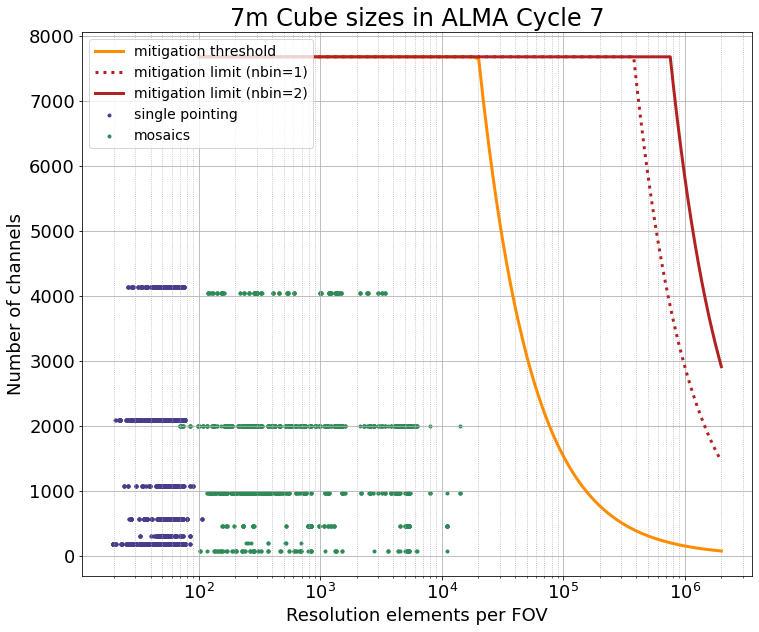

In [91]:
plt.figure(figsize=(12,10))

# calculate line for maximum number of channels
cube_limit = 40 #  GB
points_per_fov = np.linspace(100,2e6,1000)
nchan_max = calc_nchan_max(cube_limit, points_per_fov)

# calculate limit at which only one cube produced once mitigated
# I'm leaving this off since it seems to depend on max product size.
#nchan_max_1cube = calc_nchan_max(0.5 * max_cube_limit, points_per_fov, 
#                                 nbin=2.0,pixels_per_beam=9.0,frac_fov=math.log(0.7)/math.log(0.2))

# calculate maximum mitigation limit -- depends on nbin which may not be able to be set
max_cube_limit = 60 # GB
nchan_max_fail_nbin1 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=1.0, pixels_per_beam=9.0, frac_fov=0.22)

nchan_max_fail_nbin2 = calc_nchan_max(max_cube_limit, points_per_fov, 
                                nbin=2.0, pixels_per_beam=9.0, frac_fov=0.22)


# select only 12m points
mosaic_7m = (result['array'] == '7m') & (result['is_mosaic'] == 'T')
sp_7m = (result['array'] == '7m') & (result['is_mosaic'] == 'F')

plt.scatter(result[sp_7m]['points_per_fov'],result[sp_7m]['spw_nchan']+50,marker='.',
            label='single pointing',facecolor='darkslateblue')
plt.scatter(result[mosaic_7m]['points_per_fov'],result[mosaic_7m]['spw_nchan']-50,
            marker='.',label='mosaics',facecolor='seagreen')
#plt.scatter([points_per_fov_983],[nchan_983],color='magenta',marker='*',s=50,label='2017.1.00983.S')
plt.xlabel('Resolution elements per FOV',size=18)
plt.xscale('log')
plt.xticks(size=18)
plt.ylabel('Number of channels',size=18)
plt.yticks(size=18)
plt.title('7m Cube sizes in ALMA Cycle 7',size=24)

plt.plot(points_per_fov,nchan_max,color='darkorange',label='mitigation threshold', linewidth=3)
#plt.plot(points_per_fov,nchan_max_1cube,color='orange',linestyle=':',label='only one cube (est)',linewidth=3)
plt.plot(points_per_fov,nchan_max_fail_nbin1, color='firebrick',label='mitigation limit (nbin=1)',linewidth=3,
        linestyle=':')
plt.plot(points_per_fov,nchan_max_fail_nbin2, color='firebrick',label='mitigation limit (nbin=2)',linewidth=3)


plt.grid(which='major')
plt.grid(which='minor',linestyle=':')

plt.legend(loc='upper left',prop={'size':14})

#plt.axvspan(5e4,1e5,alpha=0.2,color='gray')
#plt.axvspan(3e4,6e4,alpha=0.2,color='gray')
#plt.axvspan(1e3,2e3,alpha=0.2,color='gray')
#plt.axhspan(1500,3838,alpha=0.2,color='gray')
plt.savefig("cycle7_7m_cube_size.png")

In [37]:
idx = (result['points_per_fov'] > 1e6) & (result['spw_nchan'] > 3000)
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name'].write('mitigation_fails.csv')

In [38]:
idx = (result['points_per_fov'] > 4e5) & (result['points_per_fov'] < 6e5) & (result['spw_nchan'] > 3000)
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name']

proposal_id,member_ous_uid,schedblock_name,target_name
str14,str22,str18,str29
2019.1.01739.S,uid://A001/X1465/X2fc,DF_Tau_a_06_TM1,DF_Tau
2019.1.01739.S,uid://A001/X1465/X2f6,CoKu_Tau_a_06_TM1,CoKu_Tau_4
2019.1.01739.S,uid://A001/X1465/X303,DP_Tau_a_06_TM1,DP_Tau
2019.1.01739.S,uid://A001/X1465/X2f9,ZZ_Tau_a_06_TM1,ZZ_Tau
2019.1.00703.S,uid://A001/X146a/X96,T_Tau_a_06_TM1,T_Tau
2019.1.01074.S,uid://A001/X1465/X1ad6,Elias_29_a_06_TM1,Elias_29
2019.1.01074.S,uid://A001/X1465/X1ad6,Elias_29_a_06_TM1,Elias_29
2019.1.01074.S,uid://A001/X1465/X1ad6,Elias_29_a_06_TM1,Elias_29
2019.1.01074.S,uid://A001/X1465/X1ac6,IRS_63_a_06_TM1,IRS_63


In [210]:
print("number of projects", len(np.unique(result['proposal_id'])))
print("number of mous", len(np.unique(result['member_ous_uid'])))
print("number of source/spw: ", len(result['array']))

number of projects 510
number of mous 2880
number of source/spw:  50639


In [211]:
# calculate total number of source/spw
idx = result['array'] == '12m'
print("number of projects:", len(np.unique(result[idx]['proposal_id'])))
print("number of mous:", len(np.unique(result[idx]['member_ous_uid'])))
print("number of source/spw: ", np.sum(idx))

number of projects: 414
number of mous: 1764
number of source/spw:  37393


In [212]:
idx = result['array'] == '7m'
print("number of projects", len(np.unique(result[idx]['proposal_id'])))
print("number of mous:", len(np.unique(result[idx]['member_ous_uid'])))
print("number of source/spw: ", np.sum(idx))


number of projects 120
number of mous: 910
number of source/spw:  11357


In [213]:
# calculate number of mitigated projects based on cube size
idx = (result['array'] == '12m') & (result['mitigated'] == True)
print("number of projects affected", len(np.unique(result[idx]['proposal_id'])))
print("number of mous:", len(np.unique(result[idx]['member_ous_uid'])))
print("number of source/spw mitigated:", np.sum(idx))


number of projects affected 95
number of mous: 203
number of source/spw mitigated: 1136


In [214]:
# calculate number of mitigated projects based on cube size
idx = (result['array'] == '7m') & (result['mitigated'] == True)
print("number of projects affected", len(np.unique(result[idx]['proposal_id'])))
print("number of mous:", len(np.unique(result[idx]['member_ous_uid'])))
print("number of source/spw mitigated:", np.sum(idx))

number of projects affected 0
number of mous: 0
number of source/spw mitigated: 0


# Calculating potential correlator impacts

In [246]:
# calculate total number of channels per mous
idx = (result['array'] == '12m') | (result['array'] == '7m')

mous_list = np.unique(result[idx]['member_ous_uid'])

nchan_mous =  np.array()
points_per_fov_mous = np.array()

for i in np.arange(len(mous_list)):
    idx = result['member_ous_uid'] == mous_list[i]
    src_list = np.unique(result[idx]['target_name'])
    for j in np.arange(len(src_list)):
        
        
    nchan_mous[i] = np.sum(result[idx]['spw_nchan'])
    points_per_fov_mous[i] = result[idx]['points_per_fov'][0]

In [262]:
print(len(mous_list))

2674


(array([2.587e+03, 3.100e+01, 1.500e+01, 8.000e+00, 1.200e+01, 1.200e+01,
        3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00]),
 array([2.560000e+02, 2.197760e+05, 4.392960e+05, 6.588160e+05,
        8.783360e+05, 1.097856e+06, 1.317376e+06, 1.536896e+06,
        1.756416e+06, 1.975936e+06, 2.195456e+06]),
 <BarContainer object of 10 artists>)

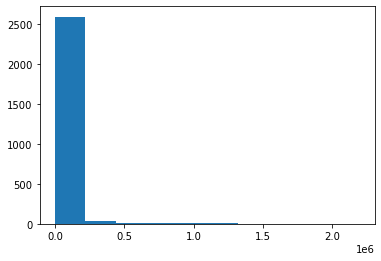

In [272]:
plt.hist(nchan_mous)
print(nchan_mous)

In [266]:
mitigated = np.full(len(mous_list), True) 

cube_limit = 40 #GB
nchan_max = calc_nchan_max(cube_limit, points_per_fov_mous, chan_limit=80*14880)

idx = nchan_mous*77.0 > nchan_max
mitigated[idx] = True

print(len(mous_list))
print(np.sum(mitigated == True))

2674
2674


In [267]:
mitigated = np.full(len(mous_list), True) 

cube_limit = 40*2 #GB
nchan_max = calc_nchan_max(cube_limit, points_per_fov_mous,chan_limit=80*14880)

idx = nchan_mous*77.0 > nchan_max
mitigated[idx] = True

print(len(mous_list))
print(np.sum(mitigated))

2674
2674


In [268]:
mitigated = np.full(len(mous_list), True) 

cube_limit = 40*10 #GB
nchan_max = calc_nchan_max(cube_limit, points_per_fov_mous,chan_limit=80*14880)

idx = nchan_mous*77.0 > nchan_max
mitigated[idx] = True

print(len(mous_list))
print(np.sum(mitigated))

2674
2674


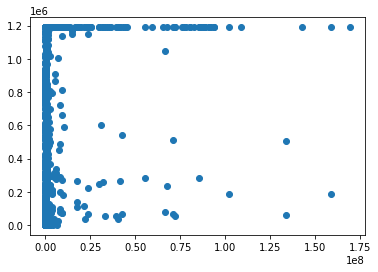

In [270]:
plt.scatter(nchan_mous*77.0, nchan_max)

In [253]:
nchan_max

array([7680.        , 7680.        , 7680.        , ..., 2014.53717449,
       7680.        , 7680.        ])

In [239]:
?np.full

# Calculating max points/fov for different cubesizes and nchan

In [285]:
def calc_max_points_per_fov(maxcubesize, nchan, pixels_per_beam=25.0, nbin=1, frac_fov = 1):
    points_per_fov = (maxcubesize * 1e9) / (4.0 * (nchan/nbin) * pixels_per_beam * 2.6 * frac_fov)
    return points_per_fov

In [274]:
old_correlator_max = 3860
new_correlator_max = 80*14880
maxcubesize = 40 #GB

In [275]:
# current max points per fov
calc_max_points_per_fov(maxcubesize, old_correlator_max)

39856.516540454366

In [276]:
calc_max_points_per_fov(maxcubesize,new_correlator_max)

129.2390405293631

In [277]:
calc_max_points_per_fov(maxcubesize*2,new_correlator_max)

258.4780810587262

In [278]:
calc_max_points_per_fov(maxcubesize*10,new_correlator_max)

1292.3904052936311

In [279]:
calc_max_points_per_fov(maxcubesize*100,new_correlator_max)

12923.90405293631

In [286]:
calc_max_points_per_fov(maxcubesize*100,new_correlator_max,nbin=2,pixels_per_beam=9)

71799.46696075729

In [287]:
calc_max_points_per_fov(maxcubesize*100,new_correlator_max,nbin=2,pixels_per_beam=9,frac_fov=0.2)

358997.3348037864

In [297]:
print('band 2 example at 0.1km/s')
print(calc_max_points_per_fov(maxcubesize,595200))
print("band 9 example at 0.1km/s")
print(calc_max_points_per_fov(maxcubesize, 74400))

band 1 example at 0.1km/s
258.4780810587262
band 9 example at 0.1km/s
2067.8246484698097


In [298]:
print('band 2 example at 0.1km/s')
print(calc_max_points_per_fov(maxcubesize*2,595200))
print("band 9 example at 0.1km/s")
print(calc_max_points_per_fov(maxcubesize*2, 74400))

band 1 example at 0.1km/s
516.9561621174524
band 9 example at 0.1km/s
4135.6492969396195


In [299]:
print('band 2 example at 0.1km/s')
print(calc_max_points_per_fov(maxcubesize*10,595200))
print("band 9 example at 0.1km/s")
print(calc_max_points_per_fov(maxcubesize*10, 74400))

band 1 example at 0.1km/s
2584.7808105872623
band 9 example at 0.1km/s
20678.2464846981


In [350]:
print('band 2 example at 0.1km/s')
print(calc_max_points_per_fov(maxcubesize*100,595200))
print("band 9 example at 0.1km/s")
print(calc_max_points_per_fov(maxcubesize*100, 74400))

band 2 example at 0.1km/s
25847.80810587262
band 9 example at 0.1km/s
206782.46484698096


In [307]:
config_res = [3.38,2.30,1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057,0.042]

config_dict = {}

i=1
for res in config_res:
    pb = 6300/100.0
    points_per_fov = (pb)**2 / res**2
    print(str(i)+","+str(res)+","+str(points_per_fov))
    config_dict['C'+str(i)] = {'res':res, 'points_per_fov': points_per_fov,'pb':pb}
    i=i+1
    
    

1,3.38,347.41430622177097
2,2.3,750.2835538752364
3,1.42,1968.3594524895855
4,0.918,4709.727028066129
5,0.545,13362.511573099906
6,0.306,42387.543252595155
7,0.211,89148.94094921499
8,0.096,430664.0625
9,0.057,1221606.648199446
10,0.042,2250000.0


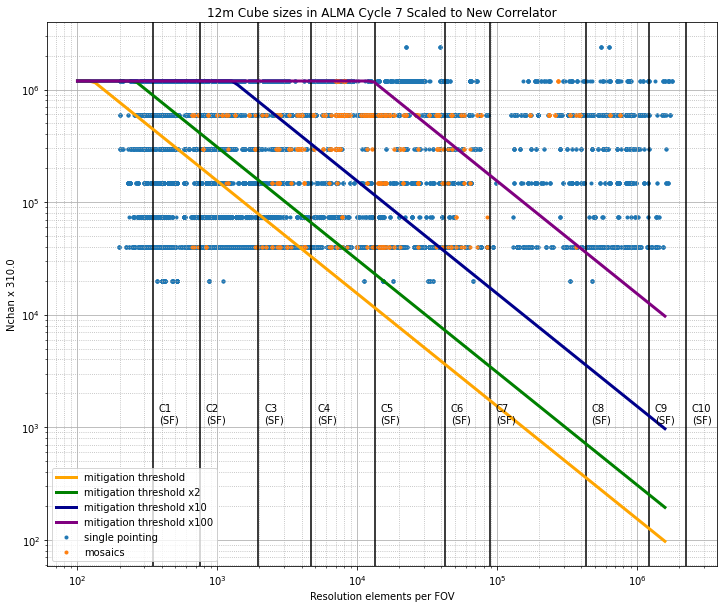

In [374]:
plt.figure(figsize=(12,10))

# calculate line for maximum number of channels
cube_limit = 40 #  GB
points_per_fov = np.logspace(2,6.2,num=100)

nchan_max = calc_nchan_max(cube_limit, points_per_fov,chan_limit = 80*14880)
nchan_max_x2 = calc_nchan_max(cube_limit*2, points_per_fov, chan_limit = 80*14880)
nchan_max_x10 = calc_nchan_max(cube_limit*10, points_per_fov, chan_limit = 80*14880)
nchan_max_x100 = calc_nchan_max(cube_limit*100, points_per_fov,  chan_limit = 80*14880)

# calculate limit at which only one cube produced once mitigated
# I'm leaving this off since it seems to depend on max product size.
#nchan_max_1cube = calc_nchan_max(0.5 * max_cube_limit, points_per_fov, 
#                                 nbin=2.0,pixels_per_beam=9.0,frac_fov=math.log(0.7)/math.log(0.2))

# select only 12m points
mosaic_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'T') 
sp_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'F') 

# highest resolution window to one window across fov
factor = (80*14880/(3840))

for config in config_dict.keys():
    plt.axvline(config_dict[config]['points_per_fov'], color= 'black')
    plt.text(config_dict[config]['points_per_fov'] * 1.1, 1100, config + '\n(SF)')
    #print(config_dict[config],config_dict[config]['points_per_fov'])
    
plt.scatter(result[sp_12m]['points_per_fov'],result[sp_12m]['spw_nchan']*factor,marker='.',label='single pointing')
plt.scatter(result[mosaic_12m]['points_per_fov'],result[mosaic_12m]['spw_nchan']*factor,marker='.',label='mosaics')
#plt.scatter([points_per_fov_983],[nchan_983],color='magenta',marker='*',s=50,label='2017.1.00983.S')
plt.xlabel('Resolution elements per FOV')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Nchan x ' + str(factor))
plt.title('12m Cube sizes in ALMA Cycle 7 Scaled to New Correlator')

plt.plot(points_per_fov,nchan_max,color='orange',label='mitigation threshold', linewidth=3)
plt.plot(points_per_fov,nchan_max_x2,color='green',label='mitigation threshold x2', linewidth=3)
plt.plot(points_per_fov,nchan_max_x10,color='darkblue',label='mitigation threshold x10', linewidth=3)
plt.plot(points_per_fov,nchan_max_x100,color='purple',label='mitigation threshold x100', linewidth=3)


#plt.plot(points_per_fov,nchan_max_1cube,color='orange',linestyle=':',label='only one cube (est)',linewidth=3)
#plt.plot(points_per_fov,nchan_max_fail_nbin1, color='magenta',label='mitigation limit (nbin=1)',linewidth=3,
#        linestyle=':')
#plt.plot(points_per_fov,nchan_max_fail_nbin2, color='magenta',label='mitigation limit (nbin=2)',linewidth=3)


plt.grid(which='major')
plt.grid(which='minor',linestyle=':')

plt.legend(loc='lower left')

#plt.axvspan(5e4,1e5,alpha=0.2,color='gray')
#plt.axvspan(3e4,6e4,alpha=0.2,color='gray')
#plt.axvspan(1e3,2e3,alpha=0.2,color='gray')
#plt.axhspan(1500,3838,alpha=0.2,color='gray')
plt.savefig("cycle7_12m_cube_size_newcorrelator.png")

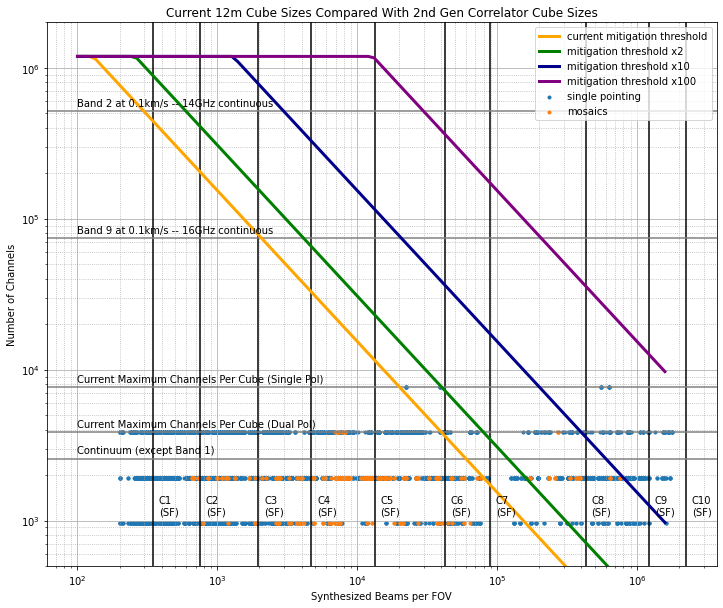

In [385]:
plt.figure(figsize=(12,10),facecolor='white')

# calculate line for maximum number of channels
cube_limit = 40 #  GB
#points_per_fov = np.linspace(100,2e6,1000)
points_per_fov = np.logspace(2,6.2,num=100)
nchan_max = calc_nchan_max(cube_limit, points_per_fov,chan_limit = 80*14880)
nchan_max_x2 = calc_nchan_max(cube_limit*2, points_per_fov, chan_limit = 80*14880)
nchan_max_x10 = calc_nchan_max(cube_limit*10, points_per_fov, chan_limit = 80 * 14880)
nchan_max_x100 = calc_nchan_max(cube_limit*100, points_per_fov,  chan_limit = 80* 14880)


# select only 12m points
mosaic_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'T') 
sp_12m = (result['array'] == '12m') & (result['is_mosaic'] == 'F') 

plt.scatter(result[sp_12m]['points_per_fov'],result[sp_12m]['spw_nchan'],marker='.',label='single pointing')
plt.scatter(result[mosaic_12m]['points_per_fov'],result[mosaic_12m]['spw_nchan'],marker='.',label='mosaics')
#plt.scatter([points_per_fov_983],[nchan_983],color='magenta',marker='*',s=50,label='2017.1.00983.S')


for config in config_dict.keys():
    plt.axvline(config_dict[config]['points_per_fov'], color= 'black')
    plt.text(config_dict[config]['points_per_fov'] * 1.1, 1100, config + '\n(SF)')
    #print(config_dict[config],config_dict[config]['points_per_fov'])
    
plt.axhline(520800,color='gray',linestyle='-')
plt.text(100, 560000, "Band 2 at 0.1km/s -- 14GHz continuous")

plt.axhline(74400,color='gray',linestyle='-')
plt.text(100, 80000, "Band 9 at 0.1km/s -- 16GHz continuous")

plt.axhline(2560,color='gray',linestyle='-')
plt.text(100, 2800, "Continuum (except Band 1)")

plt.axhline(3840, color='gray',linestyle='-')
plt.text(100, 4200, "Current Maximum Channels Per Cube (Dual Pol)")


plt.axhline(7680, color='gray',linestyle='-')
plt.text(100, 8200, "Current Maximum Channels Per Cube (Single Pol)")


plt.plot(points_per_fov,nchan_max,color='orange',label='current mitigation threshold', linewidth=3)
plt.plot(points_per_fov,nchan_max_x2,color='green',label='mitigation threshold x2', linewidth=3)
plt.plot(points_per_fov,nchan_max_x10,color='darkblue',label='mitigation threshold x10', linewidth=3)
plt.plot(points_per_fov,nchan_max_x100,color='purple',label='mitigation threshold x100', linewidth=3)

plt.xlabel('Synthesized Beams per FOV')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Channels')
plt.title('Current 12m Cube Sizes Compared With 2nd Gen Correlator Cube Sizes')

    
plt.grid(which='major')
plt.grid(which='minor',linestyle=':')

plt.ylim(500,2e6)

plt.legend(loc='upper right')

plt.savefig('correlator_impact_cycle7_noscaling.png')


# Writing out Tables

In [ ]:
# table for Remy
idx = (result['array'] == '12m') & (result['array'] == '7m')

result[idx]['proposal_id','member_ous_uid','target_name','schedblock_name','array','spw_freq',
            'nspw','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov','mitigated','failed_mitigation'].write('table_for_remy_20220109_v2.csv')

In [ ]:
idx = (result['spw_nchan'] > 3500.0)& (result['array'] == '12m') & (result['points_per_fov'] < 1e5)

result[idx]['proposal_id','member_ous_uid','target_name','schedblock_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov']

In [ ]:
result[idx]['proposal_id','member_ous_uid','target_name','schedblock_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov'].write('big_mosaic_nchan3840.csv')

In [ ]:
idx = (result['spw_nchan'] > 1500 )& (result['spw_nchan'] < 2000) & (result['array'] == '12m') & (result['points_per_fov'] > 5e4) & (result['points_per_fov'] < 1e5)

result[idx]['proposal_id','member_ous_uid','target_name','schedblock_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov']

In [ ]:
result[idx]['proposal_id','member_ous_uid','target_name','schedblock_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov'].write('big_mosaic_nchan1920.csv')

In [ ]:
idx = (result['spw_nchan'] > 1500.0)& (result['array'] == '12m') & (result['points_per_fov'] > 1e5)

result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov']

In [ ]:
result[idx]['proposal_id','member_ous_uid','schedblock_name','target_name','bandwidth','spw_specwidth','spw_nchan','pol_states', 'points_per_fov'].write('cube_over_max_cube_limit.csv')

In [ ]:
1+1